In [1]:
# Imports
import torch
import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt
import pygame
import random
import tqdm

In [2]:
# DQN model which takes in the state as an input and outputs predicted q values for every possible action
class DQN(torch.nn.Module):
    def __init__(self, state_space, action_space):
        super().__init__()
        # Add your architecture parameters here
        # You can use nn.Functional
        # Remember that the input is of size batch_size x state_space
        # and the output is of size batch_size x action_space (ulta ho sakta hai dekh lo)
        # TODO: Add code here
        
        self.w1 = torch.nn.Parameter(torch.tensor(np.random.normal(loc=0, scale=np.sqrt(2/state_space), size=(state_space, 16)), dtype=torch.float))
        self.b1 = torch.nn.Parameter(torch.tensor(np.random.normal(loc=0, scale=np.sqrt(2/state_space), size=(1, 16)), dtype=torch.float))

        self.w2 = torch.nn.Parameter(torch.tensor(np.random.normal(loc=0, scale=np.sqrt(2/16), size=(16, 8)), dtype=torch.float))
        self.b2 = torch.nn.Parameter(torch.tensor(np.random.normal(loc=0, scale=np.sqrt(2/16), size=(1, 8)), dtype=torch.float))
        
        self.w3 = torch.nn.Parameter(torch.tensor(np.random.normal(loc=0, scale=np.sqrt(2/8), size=(8, action_space)), dtype=torch.float))
        self.b3 = torch.nn.Parameter(torch.tensor(np.random.normal(loc=0, scale=np.sqrt(2/8), size=(1, action_space)), dtype=torch.float))

        self.activation = torch.nn.ReLU(inplace=True)
        self.norm = torch.nn.BatchNorm1d(1)

    def forward(self, input):
        # TODO: Complete based on your implementation
        if np.ndim(input) == 1:
            input = torch.tensor(input, dtype=torch.float).unsqueeze(dim=0)
        else:
            input = torch.tensor(input, dtype=torch.float)

        input[:, 0] /= 4.8
        input[:, 1] /= 3.5
        input[:, 2] /= 12
        input[:, 3] /= 3
        # input = self.norm(input)
        
        input = torch.matmul(input, self.w1) + self.b1
        self.activation(input)

        input = torch.matmul(input, self.w2) + self.b2
        self.activation(input)
        
        input = torch.matmul(input, self.w3) + self.b3

        return input
    


In [3]:
# While training neural networks, we split the data into batches.
# To improve the training, we need to remove the "correlation" between game states
# The buffer starts storing states and once it reaches maximum capacity, it replaces
# states at random which reduces the correlation.
class ExperienceBuffer:
    def __init__(self, capacity):

        self.buffer = torch.zeros(size=(capacity, 2), dtype=torch.float)
        self.actions = torch.zeros(size=(capacity, 1), dtype=torch.long)
        self.buffer_states = torch.zeros(size=(capacity, 4), dtype=torch.float)
        self.buffer_nextstates = torch.zeros(size=(capacity, 4), dtype=torch.float)

        # total samples collected
        self.occupied = 0

        self.cap = capacity

    
    def push(self, state, action, reward, next_state, done):  
        
        if self.occupied < self.cap:
            index = self.occupied
        else:
            # after being filled replacing randomly
            index = np.random.randint(low =0, high=self.occupied)

        self.buffer[index][0] = reward
        self.buffer[index][1] = done

        self.actions[index] = action
        self.buffer_states[index] = torch.tensor(state, dtype=torch.float)
        self.buffer_nextstates[index] = torch.tensor(next_state, dtype=torch.float)
        
        self.occupied += 1
        self.occupied = min(self.occupied, self.cap)

    def sample(self, batch_size):

        batch = torch.randint(0, self.occupied, size=(batch_size,))

        return self.buffer[batch], self.actions[batch], self.buffer_states[batch], self.buffer_nextstates[batch]
    
    def filled(self, batch):
        
        return self.occupied >= batch 


In [4]:
import copy

# TODO: Implement training logic for CartPole environment here
# Remember to use the ExperienceBuffer and a target network
# Details can be found in the book sent in the group

env = gym.make(id='CartPole-v1', max_episode_steps=-1)

q_net = DQN(4, 2)
target_net = copy.deepcopy(q_net)

replay_buffer = ExperienceBuffer(10000)
# temp_buffer = []

epochs = 1000
epsilon = 1
batch_size = 128
gamma = 0.99
loss_fn = torch.nn.MSELoss()
optimizer_seq = torch.optim.Adam(q_net.parameters(), lr=0.0003)

results = np.zeros(epochs)

steps_till_update = 0
step_count = 0
for i in tqdm.tqdm(range(epochs)):
    
    state = env.reset()[0]
    done = False
    total_reward = 0
    step_count = 0

    greedy = False
    
    while not done:

        optimizer_seq.zero_grad()

        # selecting action
        if np.random.rand() < epsilon:
            action = np.random.randint(0, 2)
            greedy = True
        else:
            action = torch.argmax(q_net(torch.tensor(state)))
            greedy = False

        next_state, reward, done, _, _ = env.step(int(action))

        if (not greedy) or epsilon > 0.3:
            replay_buffer.push(state, action, reward, next_state, done)
            # temp_buffer.append((state, action, reward, next_state, done))

        total_reward += reward
        steps_till_update += 1
        step_count += 1
        state = next_state

        if replay_buffer.filled(batch_size):

            data, actions, states, next_states = replay_buffer.sample(batch_size)

            with torch.no_grad():
                targets = data[:, 0] + gamma*torch.max(target_net.forward(next_states), dim=1).values*(1-data[:, 1])

            loss = loss_fn(q_net.forward(states).gather(1, actions).squeeze(1), targets)
            loss.backward()
            optimizer_seq.step()

        # if step_count > 1000:
        #     print(f"Episode {i}: Step {step_count}, Reward: {total_reward}, Done: {done}")
        #     done = True

        # updating target net
        if steps_till_update == max(i, 50):
            steps_till_update = 0
            target_net = copy.deepcopy(q_net)

    # n = len(temp_buffer)
    # if n > 0:
    #     probs = np.arange(1, n+1)
    #     probs = probs[0]/probs.sum()
    #     for j in np.random.choice(np.arange(n), size=n//2, p=probs, replace=False):
    #         replay_buffer.push(*temp_buffer[j])
            
    # temp_buffer = []

    if epsilon > 0.2:
        epsilon = max(0.2, 1-i*0.8/600)

    results[i] = total_reward
    total_reward = 0


  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_8632\1697577348.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=torch.float).unsqueeze(dim=0)
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_8632\1697577348.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=torch.float)
100%|██████████| 1000/1000 [05:30<00:00,  3.02it/s]


Best run: 31523.0, at episode: 922


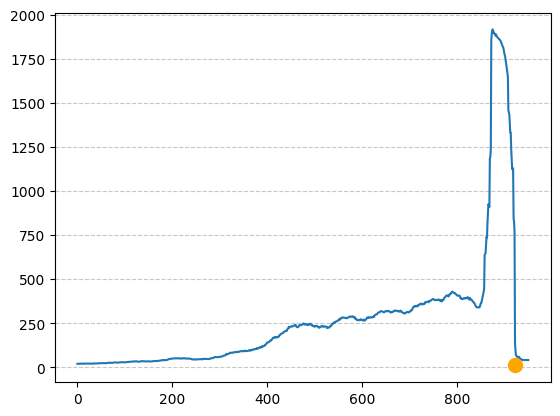

In [5]:
# plt.plot(np.convolve(results, np.ones(1)/1, 'valid'))
plt.plot(np.convolve(results, np.ones(50)/50, 'valid'))
plt.grid(axis='y', linestyle='--', alpha=0.7)
print(f"Best run: {max(results)}, at episode: {np.argmax(results)+1}")
# plt.scatter(np.argmax(results), max(results), color='orange', s=100, zorder=5)
plt.scatter(np.argmax(results), 10, color='orange', s=100, zorder=5)

In [6]:
def evaluate_cartpole_model(model, episodes=10, render=True):
    env = gym.make("CartPole-v1", render_mode="human" if render else None)
    obs_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n

    model.eval()

    rewards = []
    velocities = []
    ang_velocities = []

    for episode in range(episodes):
        obs, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                q_values = model(state)
                action = torch.argmax(q_values, dim=1).item()

            obs, reward, done, _, _ = env.step(action)
            # print(f"velocity: {obs[1]}")
            # velocities.append(obs[1])
            # ang_velocities.append(obs[3])
            total_reward += reward

            if total_reward >= 100000:
                done = True


            if render:
                env.render()

        rewards.append(total_reward)
        print(f"Episode {episode + 1}: Reward = {total_reward}")
        # plt.plot(velocities)
        # plt.plot(ang_velocities)
        # plt.show()
        velocities = []

    env.close()
    avg_reward = sum(rewards) / episodes
    print(f"Average reward over {episodes} episodes: {avg_reward}")

In [10]:
# TODO: Run evaluation for cartpole here
# evaluate_cartpole_model(DQN(2, 4), episodes=5)
evaluate_cartpole_model(q_net, episodes=10, render=False)

C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_8632\1697577348.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=torch.float)


Episode 1: Reward = 15.0
Episode 2: Reward = 15.0
Episode 3: Reward = 12.0
Episode 4: Reward = 100000.0
Episode 5: Reward = 15.0
Episode 6: Reward = 14.0
Episode 7: Reward = 13.0
Episode 8: Reward = 14.0
Episode 9: Reward = 15.0
Episode 10: Reward = 14.0
Average reward over 10 episodes: 10012.7


most of the time it falls over instantly but when it manages to get past the start it keep on going indefinitely

maybe due to very long episodes the agent overfits to the end/middle of the episode and kinda forgets about how to begin

In [3]:
# While training neural networks, we split the data into batches.
# To improve the training, we need to remove the "correlation" between game states
# The buffer starts storing states and once it reaches maximum capacity, it replaces
# states at random which reduces the correlation.
class snake_ExperienceBuffer:
    def __init__(self, capacity, map_size):

        self.buffer = torch.zeros(size=(capacity, 2), dtype=torch.float)
        self.actions = torch.zeros(size=(capacity, 1), dtype=torch.long)
        # self.next_actions = torch.zeros(size=(capacity, 1), dtype=torch.long)
        self.buffer_states = torch.zeros(size=(capacity, 4), dtype=torch.float)
        self.buffer_nextstates = torch.zeros(size=(capacity, 4), dtype=torch.float)
        # self.buffer_states = torch.zeros(size=(capacity, 1, map_size+2, map_size+2), dtype=torch.float)
        # self.buffer_nextstates = torch.zeros(size=(capacity, 1, map_size+2, map_size+2), dtype=torch.float)

        # total samples collected
        self.occupied = 0

        self.cap = capacity

    
    def push(self, state, action, reward, next_state, done):  
        
        if self.occupied < self.cap:
            index = self.occupied
        else:
            # after being filled replacing randomly
            index = np.random.randint(low =0, high=self.occupied)

        self.buffer[index][0] = reward
        self.buffer[index][1] = done

        self.actions[index] = action
        self.buffer_states[index] = torch.tensor(state, dtype=torch.float)
        self.buffer_nextstates[index] = torch.tensor(next_state, dtype=torch.float)
        
        self.occupied += 1
        self.occupied = min(self.occupied, self.cap)

    def sample(self, batch_size):

        batch = torch.randint(0, self.occupied, size=(batch_size,))

        return self.buffer[batch], self.actions[batch], self.buffer_states[batch], self.buffer_nextstates[batch]
    
    def filled(self, batch):
        
        return self.occupied >= batch 



In [4]:
class SnakeGame(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 10}

    def __init__(self, size=10, render_mode=None):
        super().__init__()
        self.size = size
        self.cell_size = 30
        self.screen_size = self.size * self.cell_size
        self.render_mode = render_mode

        self.action_space = gym.spaces.Discrete(4)  # 0: right, 1: up, 2: left, 3: down
        # self.observation_space = gym.spaces.Box(-1, 1, shape=(self.size+2, self.size+2), dtype=np.float32)
        self.observation_space = gym.spaces.Box(-1, 1, shape=(4,), dtype=np.float32)

        self.screen = None
        self.clock = None

        self.snake = deque()


        #####
        mid = self.size // 2
        self.snake.appendleft([mid, mid])
        self.direction = [1, 0]
        self.food = None
        self._place_food()
        #####

        
        if self.render_mode == "human":
            pygame.init()
            self.screen = pygame.display.set_mode((self.screen_size, self.screen_size))
            self.clock = pygame.time.Clock()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.snake.clear()
        mid = self.size // 2
        self.direction = [1, 0]
        self.snake.appendleft([np.random.randint(low=1, high=self.size), np.random.randint(low=1, high=self.size)])
        self._place_food()
        obs = self._get_obs()

        if self.render_mode == "human":
            self._render_init()

        return obs, {}
    

    def step(self, action):
        # TODO: Change reward schema to avoid the following
        # 1) 180 degree turns
        # 2) Wall collisions
        # 3) Being slow at collecting food

        reward = 0

        if action == 0:
            if self.direction != [-1, 0] or len(self.snake) == 1: 
                self.direction = [1, 0]
            else:
                reward -= 100
        elif action == 1:
            if self.direction != [0, 1] or len(self.snake) == 1: 
                self.direction = [0, -1]
            else:
                reward -= 100
        elif action == 2:
            if self.direction != [1, 0] or len(self.snake) == 1: 
                self.direction = [-1, 0]
            else:
                reward -= 100
        elif action == 3:
            if self.direction != [0, -1] or len(self.snake) == 1: 
                self.direction = [0, 1]
            else:
                reward -= 100
        # elif action == 1 and self.direction != [0, 1]: self.direction = [0, -1]
        # elif action == 2 and self.direction != [1, 0]: self.direction = [-1, 0]
        # elif action == 3 and self.direction != [0, -1]: self.direction = [0, 1]

        

        head = self.snake[0]
        new_head = [head[0] + self.direction[0], head[1] + self.direction[1]]

        done = False

        if not (0 <= new_head[0] < self.size and 0 <= new_head[1] < self.size):
            done = True
            # reward = -100
        else:
            body_to_check = list(self.snake)[:-1] if new_head != self.food else list(self.snake)
            if new_head in body_to_check:
                done = True
                # reward = -100

        # Calculate distance to food before and after the move
        old_dist = abs(head[0] - self.food[0]) + abs(head[1] - self.food[1])
        new_dist = abs(new_head[0] - self.food[0]) + abs(new_head[1] - self.food[1])

        if new_head == self.food:
            reward += 200  # food reward
        elif done:
            reward += -200  # death
        else:
            reward += (old_dist - new_dist) * 100  # Reward moving toward food
            reward -= 50 # stopping from moving in circles

        if not done:
            self.snake.appendleft(new_head)
            if new_head == self.food:
                self._place_food()
                if self.food == None:
                    done = True
                # reward = 30
            else:
                self.snake.pop()
                # reward = -0.5 

        if not done:
            obs = self._get_obs()
        else:
            obs = torch.zeros(size=(4,))

        if self.render_mode == "human":
            self.render()


        return obs, reward, done, False, {}

    def _get_obs(self):
        # TODO: Return an observation state, take inspiration from the observation_space attribute
        # obs = torch.zeros(size=(1, self.size+2, self.size+2))

        # # -1 for walls
        # obs[0, 0] = -1
        # obs[0, :, 0] = -1
        # obs[0, :, self.size+1] = -1
        # obs[0, self.size+1] = -1

        # # -1 for snake's body except head
        # for i, j in self.snake:
        #     obs[0, i+1, j+1] = -1

        # # 3 for head
        # obs[0, self.snake[0][0]+1, self.snake[0][1]+1] = 0.5

        # # food
        # obs[0, self.food[0]+1, self.food[1]+1] = 1

        # this will help generalize across states using symmetry to combine "diff" states into one idk if it was already happening due to cnn
        obs = torch.zeros(size=(4, ))

        # snake vertical
        i, j = self.snake[0][0], self.snake[0][1]
        dist = 0
        direc = self.direction[0] + self.direction[1]
        inv = 1
        food = self.food
        snake = self.snake
        if self.direction[1] == 0:
            i, j = j, i
            inv = -1
            food = [self.food[1], self.food[0]]
            snake = []
            for [l, k] in self.snake:
                snake.append([k, l])

            # the front dir
        dist = direc
        while 0 <= j + dist <  self.size:
            if [i, j + dist] == food:
                obs[1] =  1    # ## #
                break
            elif [i, j + dist] in snake:
                obs[1] = -1 + (abs(dist) - 1)/self.size     # ## #
                break
            dist += direc

        if j + dist == self.size or j+dist == -1:
            obs[1] = -1 + (abs(dist) - 1)/self.size
        
        # the sides
        
        # left
        dist = inv*direc
        while 0 <= i + dist <  self.size:
            if [i+dist, j] == food:
                obs[0] = 1     # ## #
                break
            elif [i+dist, j] in snake:
                obs[0] = -1 + (abs(dist) - 1)/self.size    # ## #
                break
            dist += inv*direc
        
        if i + dist == self.size or i + dist == -1:
            obs[0] = -1 + (abs(dist) - 1)/self.size

        
        # right
        dist = -inv*direc
        while 0 <= i + dist <  self.size:

            if [i+dist, j] == food:
                obs[2] = 1     # ## #
                break
            elif [i+dist, j] in snake:
                obs[2] = -1 + (abs(dist) - 1)/self.size    # ## #
                break
            dist += -inv*direc
        
        if i + dist == self.size or i + dist == -1:
            obs[2] = -1 + (abs(dist) - 1)/self.size


        vec = pygame.math.Vector2((self.food[0] - self.snake[0][0], self.food[1] - self.snake[0][1]))
        # ang = vec.angle_to(self.direction)
        ang = vec.dot(self.direction)/(vec.magnitude())

        obs[3] = ang

        # else: 
        #     # the front dir
        #     dist = self.direction[0]
        #     while 0 <= i + dist <  self.size:
        #         if [i+dist, j] == self.food:
        #             obs[1] =  1    # ## #
        #             break
        #         elif [i+dist, j] in self.snake:
        #             obs[1] = -1 + (abs(dist) - 1)/self.size     # ## #
        #             break
        #         dist += self.direction[0]

        #     if i + dist == self.size or i+dist == -1:
        #         obs[1] = -1 + (abs(dist) - 1)/self.size
            
        #     # the sides
            
        #     # left
        #     dist = self.direction[0]
        #     while 0 <= i + dist <  self.size:
        #         if [i, j+dist] == self.food:
        #             obs[0] = 1     # ## #
        #             break
        #         elif [i, j+dist] in self.snake:
        #             obs[0] = -1 + (abs(dist) - 1)/self.size    # ## #
        #             break
        #         dist += self.direction[1]
            
        #     if i + dist == self.size or i + dist == -1:
        #         obs[0] = -1 + (abs(dist) - 1)/self.size

            
        #     # right
        #     dist = self.direction[0]
        #     while 0 <= i <  self.size:
        #         i += -self.direction[1]  
        #         if [i, j+dist] == self.food:
        #             obs[2] = 1     # ## #
        #             break
        #         elif [i, j+dist] in self.snake:
        #             obs[2] = -1 + (abs(dist) - 1)/self.size    # ## #
        #             break
            
        #     if i + dist == self.size or i + dist == -1:
        #         obs[2] = -1 + (abs(dist) - 1)/self.size
            

        return obs

    def _place_food(self):
        positions = set(tuple(p) for p in self.snake)
        empty = [(x, y) for x in range(self.size) for y in range(self.size) if (x, y) not in positions]
        self.food = list(random.choice(empty)) if empty else None

    def render(self):
        if self.screen is None:
            self._render_init()

        self.screen.fill((0, 0, 0))
        for x, y in self.snake:
            pygame.draw.rect(
                self.screen, (0, 255, 0),
                pygame.Rect(x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size)
            )
        if self.food:
            fx, fy = self.food
            pygame.draw.rect(
                self.screen, (255, 0, 0),
                pygame.Rect(fx * self.cell_size, fy * self.cell_size, self.cell_size, self.cell_size)
            )

        pygame.display.flip()
        self.clock.tick(self.metadata["render_fps"])

    def _render_init(self):
        pygame.init()
        self.screen = pygame.display.set_mode((self.size * self.cell_size, self.size * self.cell_size))
        self.clock = pygame.time.Clock()

    def close(self):
        if self.screen:
            pygame.quit()
            self.screen = None

In [6]:
sanke_QN = torch.nn.Sequential(

    torch.nn.Conv2d(1, 4, 3, padding=1),
    # torch.nn.BatchNorm2d(4),
    torch.nn.ReLU(),
    torch.nn.Conv2d(4, 8, 3, padding=1), 
    torch.nn.BatchNorm2d(8),
    torch.nn.ReLU(),

    torch.nn.Flatten(),
    torch.nn.Linear(8 * (12+2) * (12+2), 128),
    torch.nn.ReLU(),
    # torch.nn.Linear(128, 32),
    # torch.nn.ReLU(),
    torch.nn.Linear(128, 4)
)

In [15]:
torch.sum(torch.softmax(target_net(next_states[i].unsqueeze(0)).reshape(4,), dim=0))

NameError: name 'target_net' is not defined

In [56]:
# TODO: Implement training logic for Snake Game here

import copy

def train(model, epoch=1000, gamm=0.99, size=12, rend=False):

    if rend:
        env = SnakeGame(size, render_mode="human")
    else:
        env = SnakeGame(size)

    q_net = model
    target_net = copy.deepcopy(q_net)

    replay_buffer = snake_ExperienceBuffer(10000, size)
    # temp_buffer = []

    epochs = epoch
    epsilon = 1
    batch_size = 128
    gamma = gamm
    # loss_fn = torch.nn.HuberLoss()
    loss_fn = torch.nn.MSELoss()
    optimizer_seq = torch.optim.Adam(q_net.parameters(), lr=0.0003)

    results = np.zeros(epochs)

    steps_till_update = 0
    step_count = 0
    for i in tqdm.tqdm(range(epochs)):

        state = env.reset()[0]
        done = False
        total_reward = 0
        step_count = 0

        greedy = False

        # with torch.no_grad():
        #     # action = np.random.choice(np.arange(start=0, stop=4), size=1, p=torch.softmax(q_net(state.unsqueeze(0)).reshape(4,), dim=0).numpy())[0]
        #     action = np.argmax(target_net(state.unsqueeze(0)))
        # # next_action = 0

        action = np.random.randint(0, 4)
        rel_action = np.random.randint(0, 3)

        while not done:

            optimizer_seq.zero_grad()

            next_state, reward, done, _, _ = env.step(int(action))
            
            if (not greedy) or epsilon > 0:
                # temp_buffer.append((state, action, reward, next_state, done))
                replay_buffer.push(state, rel_action, reward, next_state, done)

            # selecting next action
            if np.random.rand() < epsilon and not torch.sum(next_state[0:3] == -1):
                rel_action = np.random.randint(0, 3)
                greedy = True
            else:
                with torch.no_grad():
                    # next_action = np.random.choice(np.arange(start=0, stop=4), size=1, p=torch.softmax(q_net(next_state.unsqueeze(0)).reshape(4,), dim=0).numpy())[0]
                    rel_action = np.argmax(q_net(next_state.unsqueeze(0)))
                    # print(action)
                greedy = False

            # converting the action
            # 
            # 0: right, 1: up, 2: left, 3: down 
            dire = env.direction
            if dire[1] == 0:
                action = (dire[0] - rel_action)%4
            else:
                action = (1 - dire[1] - rel_action)%4
                # match rel_action:
                #     case 0:
                #         action = 1
                #     case 1:
                #         action = 0
                #     case 2:
                #         action = 3

            total_reward += reward
            steps_till_update += 1
            step_count += 1
            state = next_state
            # action = next_action

            if replay_buffer.filled(batch_size):
            
                data, actions, states, next_states = replay_buffer.sample(batch_size)

                with torch.no_grad():
                    # next_action = torch.zeros(size=(batch_size, 1), dtype=torch.int64)
                    # for i in range(batch_size):
                    #     next_action[i, 0] = int(np.random.choice(np.arange(start=0, stop=4), size=1, p=torch.softmax(target_net(next_states[i].unsqueeze(0)).reshape(4,), dim=0).numpy()))
                    # targets = data[:, 0] + gamma*target_net.forward(next_states).gather(1, next_actions)*(1-data[:, 1])
                    # print("target_net(next_states) shape:", target_net(next_states).shape)
                    targets = data[:, 0] + gamma*torch.max(target_net.forward(next_states), dim=1).values*(1-data[:, 1])

                loss = loss_fn(q_net.forward(states).gather(1, actions).squeeze(1), targets)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(q_net.parameters(), max_norm=10)
                optimizer_seq.step()


            # updating target net
            if steps_till_update == min(i, 100):
            # if steps_till_update == max(i, 50):
                steps_till_update = 0
                target_net = copy.deepcopy(q_net)

            if total_reward <= -1000:
                done = True

        # n = len(temp_buffer)
        # if n > 0:
        #     probs = np.arange(1, n+1)
        #     probs = probs/probs.sum()  # Normalize to sum to 1
        #     for j in np.random.choice(np.arange(n), size=n//2, p=probs, replace=False):
        #         replay_buffer.push(*temp_buffer[j])

        # temp_buffer = []

        if epsilon > 0.05:
            epsilon = max(0.01, 1-i*0.99/(epoch))

        results[i] = total_reward
        total_reward = 0

    return results


In [2]:
def plot_progress(results):
    # plt.plot(np.convolve(results, np.ones(1)/1))
    plt.plot(np.convolve(results, np.ones(50)/50, 'valid'))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    print(f"Best run: {max(results)}, at episode: {np.argmax(results)+1}")
    plt.scatter(np.argmax(results), 10, color='orange', s=100, zorder=5)

In [27]:
res = train(sanke_QN, epoch=1000, gamm=0.4)
plot_progress(res)

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_34700\307997279.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_states[index] = torch.tensor(state, dtype=torch.float)
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_34700\307997279.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_nextstates[index] = torch.tensor(next_state, dtype=torch.float)
  0%|          | 0/1000 [00:00<?, ?it/s]


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 3]

Best run: 3450.0, at episode: 570


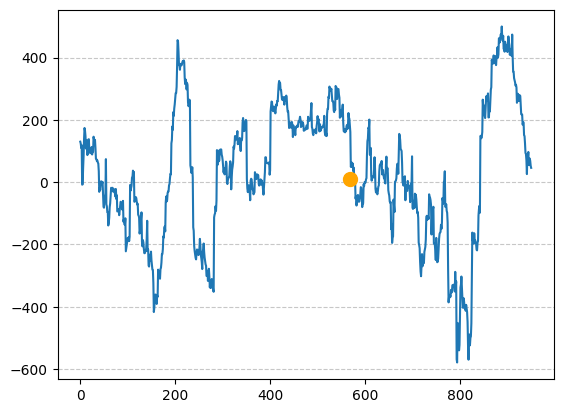

In [74]:
plot_progress(res)

In [54]:
sNAke_QN = torch.nn.Sequential(

    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 12),
    torch.nn.ReLU(),
    torch.nn.Linear(12, 3)
    # torch.nn.ReLU(),
    # torch.nn.Linear(3, 32)
)

ratio eating self and going directly toward red was low so reduced map size

  0%|          | 0/5000 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_24520\3119640414.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_states[index] = torch.tensor(state, dtype=torch.float)
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_24520\3119640414.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_nextstates[index] = torch.tensor(next_state, dtype=torch.float)
100%|██████████| 5000/5000 [03:09<00:00, 26.45it/s]


Best run: 4350.0, at episode: 872


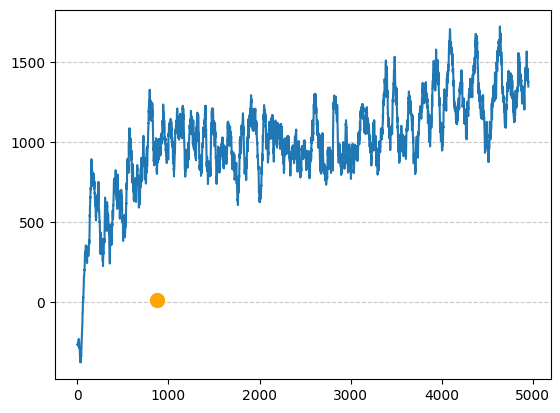

In [57]:
res = train(sNAke_QN, epoch=5000, gamm=0.99, size=4, rend=False)
plot_progress(res)

  0%|          | 0/5000 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_24520\3119640414.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_states[index] = torch.tensor(state, dtype=torch.float)
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_24520\3119640414.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_nextstates[index] = torch.tensor(next_state, dtype=torch.float)
100%|██████████| 5000/5000 [08:01<00:00, 10.39it/s]

Best run: 13700.0, at episode: 4942


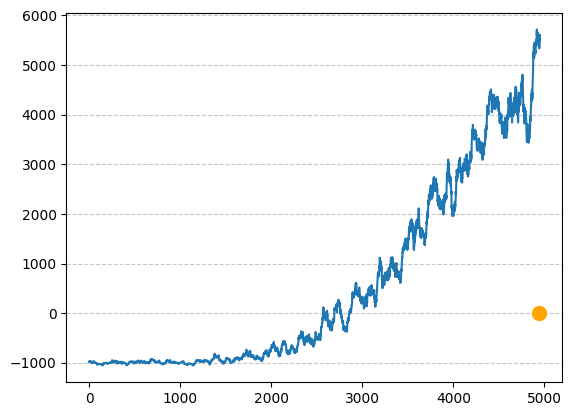

In [ ]:
res = train(sNAke_QN, epoch=5000, gamm=0.99, size=12, rend=False)
plot_progress(res)

In [48]:
import time

def evaluate_snake_model(model, size=20, episodes=10, render=True, epsil = 0, wait=False):
    env = SnakeGame(size=size, render_mode="human" if render else None)
    model.eval()

    rewards = []

    time.sleep(3)
    for episode in range(episodes):
        obs, _ = env.reset()
        total_reward = 0
        done = False

        state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        rel_action = np.random.randint(low=0, high=3)
        # with torch.no_grad():
        #     q_values = model(state)
        #     action = torch.argmin(q_values, dim=1).item()


        while not done:

            if not done:
                dire = env.direction
                if dire[1] == 0:
                    action = (dire[0] - rel_action)%4
                else:
                    action = (1 - dire[1] - rel_action)%4

                # print(f"direc {env.direction}")
                # print(f"action {action}, rel action {rel_action}")
                obs, reward, done, _, _ = env.step(action)
                # print("-"*10)
                total_reward += reward

            state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)

            # print("obs", state)
            if np.random.rand() < epsil and not torch.sum(state[0, 0:3] == -1):
                rel_action = np.random.randint(low=0, high=3)
                # print(f"explored")
            else:
                with torch.no_grad():
                    q_values = model(state)
                    # print(q_values)
                    rel_action = torch.argmax(q_values).item()
                # action = np.random.choice(np.arange(start=0, stop=4), size=1, p=torch.softmax(q_net(state).reshape(4,), dim=0).numpy())[0]
                # action = torch.argmax(q_values, dim=1).item()


            # np.argsort(q_values)
            # for i in range(size+2):
            #     for j in range(size+2):
            #         print(obs[0][i][j], end="")
            #     print()
            # print(obs)


            # for i in np.argsort(q_values[0]):
            #     match i:
            #         case 0:
            #             print(f"left: {int(q_values[0][i])}", end=" ")    
            #         case 1:
            #             print(f"straight: {int(q_values[0][i])}", end=" ")    
            #         case 2:
            #             print(f"right: {int(q_values[0][i])}", end=" ")    
            #         case 3:
            #             print(f"down: {int(q_values[0][i])}", end=" ")    

            # print()
            # for i in np.argsort(q_values[0]):
            #     match i:
            #         case 0:
            #             print(f"right: {int(q_values[0][i])}", end=" ")    
            #         case 1:
            #             print(f"up: {int(q_values[0][i])}", end=" ")    
            #         case 2:
            #             print(f"left: {int(q_values[0][i])}", end=" ")    
            #         case 3:
            #             print(f"down: {int(q_values[0][i])}", end=" ")    

            # print()
            
            waiting = wait
            while waiting:
                for event in pygame.event.get():
                    if event.type == pygame.KEYDOWN:
                        if event.key == pygame.K_n:
                            waiting = False
                        if event.key == pygame.K_ESCAPE:
                            done = True
                            waiting = False
            # print(total_reward)
            # if render:
                # env.render()
    
        rewards.append(total_reward)
        print(f"Episode {episode + 1}: Reward = {total_reward}")

    env.close()
    avg_reward = sum(rewards) / episodes

    print(f"Average reward over {episodes} episodes: {avg_reward}")

In [68]:
# TODO: Run evaluation for Snake Game here
# env.close()
evaluate_snake_model(sNAke_QN, size=12, episodes=50, render=False, epsil=0, wait = False)
# evaluate_snake_model(sNAke_QN, size=4, episodes=50, render=True, epsil=0, wait = True)

C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_24520\220984227.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_24520\220984227.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)


Episode 1: Reward = 4150
Episode 2: Reward = 8900
Episode 3: Reward = 8000
Episode 4: Reward = 3300
Episode 5: Reward = -200
Episode 6: Reward = 7500
Episode 7: Reward = 11500
Episode 8: Reward = 9750
Episode 9: Reward = 4000
Episode 10: Reward = 8850
Episode 11: Reward = 14000
Episode 12: Reward = 5350
Episode 13: Reward = 6550
Episode 14: Reward = 4750
Episode 15: Reward = 6350
Episode 16: Reward = 5750
Episode 17: Reward = 4250
Episode 18: Reward = 4700
Episode 19: Reward = 2450
Episode 20: Reward = 9550
Episode 21: Reward = 5750
Episode 22: Reward = -200
Episode 23: Reward = 7300
Episode 24: Reward = 2450
Episode 25: Reward = 10250
Episode 26: Reward = -200
Episode 27: Reward = 4200
Episode 28: Reward = 4550
Episode 29: Reward = 6750
Episode 30: Reward = 8450
Episode 31: Reward = 5350
Episode 32: Reward = 11900
Episode 33: Reward = 3200
Episode 34: Reward = 13150
Episode 35: Reward = 9150
Episode 36: Reward = 3250
Episode 37: Reward = 4800
Episode 38: Reward = 4200
Episode 39: Rewa

In [3]:
# While training neural networks, we split the data into batches.
# To improve the training, we need to remove the "correlation" between game states
# The buffer starts storing states and once it reaches maximum capacity, it replaces
# states at random which reduces the correlation.
class chaser_ExperienceBuffer:
    def __init__(self, capacity):

        self.buffer = torch.zeros(size=(capacity, 2), dtype=torch.float)
        self.actions = torch.zeros(size=(capacity, 1), dtype=torch.long)
        # self.next_actions = torch.zeros(size=(capacity, 1), dtype=torch.long)
        self.buffer_states = torch.zeros(size=(capacity, 10), dtype=torch.float)
        self.buffer_nextstates = torch.zeros(size=(capacity, 10), dtype=torch.float)

        # total samples collected
        self.occupied = 0

        self.cap = capacity

    
    def push(self, state, action, reward, next_state, done):  
        
        if self.occupied < self.cap:
            index = self.occupied
        else:
            # after being filled replacing randomly
            index = np.random.randint(low =0, high=self.occupied)

        self.buffer[index][0] = reward
        self.buffer[index][1] = done

        self.actions[index] = action
        self.buffer_states[index] = torch.tensor(state, dtype=torch.float)
        self.buffer_nextstates[index] = torch.tensor(next_state, dtype=torch.float)
        
        self.occupied += 1
        self.occupied = min(self.occupied, self.cap)

    def sample(self, batch_size):

        batch = torch.randint(0, self.occupied, size=(batch_size,))

        return self.buffer[batch], self.actions[batch], self.buffer_states[batch], self.buffer_nextstates[batch]
    
    def filled(self, batch):
        
        return self.occupied >= batch 



In [90]:
class ChaseEscapeEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 30}

    def __init__(self, render_mode=None):
        super().__init__()

        self.dt = 0.1
        self.max_speed = 0.4
        self.agent_radius = 0.05
        self.target_radius = 0.05
        self.chaser_radius = 0.07
        self.chaser_speed = 0.03


        self.action_space = gym.spaces.MultiDiscrete([3, 3])  # actions in {0,1,2} map to [-1,0,1]
        self.observation_space = gym.spaces.Box(
            low=-1,
            high=1,
            shape=(10,),
            dtype=np.float32,
        )

        self.render_mode = render_mode
        self.screen_size = 500
        self.np_random = None

        if render_mode == "human":
            pygame.init()
            self.screen = pygame.display.set_mode((self.screen_size, self.screen_size))
            self.clock = pygame.time.Clock()

    def sample_pos(self, far_from=None, min_dist=0.5):
        while True:
            pos = self.np_random.uniform(low=-0.8, high=0.8, size=(2,))
            if far_from is None or np.linalg.norm(pos - far_from) >= min_dist:
                return pos

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.agent_pos = self.sample_pos()
        self.agent_vel = np.zeros(2, dtype=np.float32)
        self.target_vel = 2*np.random.rand(2,) - 1
        self.target_pos = self.sample_pos(far_from=self.agent_pos, min_dist=0.5)
        self.chaser_pos = self.sample_pos(far_from=self.agent_pos, min_dist=0.7)

        dist_to_target = np.linalg.norm(self.agent_pos - self.target_pos)
        dist_to_chaser = np.linalg.norm(self.agent_pos - self.chaser_pos)

        return self._get_obs(dist_to_chaser, dist_to_target), {}

    def _get_obs(self, chaser_dist, target_dist):
        # TODO: Decide how to pass the state (don't use pixel values)
        
        obs = torch.zeros(size=(10,))

        obs[7] = chaser_dist/2
        obs[8], obs[9] = (self.chaser_pos - self.agent_pos)/chaser_dist

        obs[0] = target_dist/2
        obs[1], obs[2] = (self.target_pos - self.agent_pos)/target_dist

        obs[3], obs[4] = abs(self.agent_pos[0]), abs(self.agent_pos[1])
        obs[5], obs[6] = torch.tensor(self.agent_vel, dtype=torch.float)

        return obs

    def _get_info(self):
        return {}

    def step(self, action):
        # TODO: Add reward scheme
        # 1) Try to make the agent stay within bounds
        # 2) The agent shouldn't idle around
        # 3) The agent should go for the reward
        # 4) The agent should avoid the chaser

        reward = 0.0


        accel = (np.array(action) - 1) * 0.1
        self.agent_vel += accel
        self.agent_vel = np.clip(self.agent_vel, -self.max_speed, self.max_speed)
        self.agent_pos += self.agent_vel * self.dt
        self.agent_pos = np.clip(self.agent_pos, -1, 1)

        # self.target_pos += self.target_vel*self.dt
        
        if abs(self.target_pos[1]) >= 1 or abs(self.target_pos[0]) >= 1:
            self.target_vel = 2*np.random.rand(2,) - 1
        
        self.target_pos = np.clip(self.target_pos, -1, 1)
        


        if abs(self.agent_pos[0]) >= 0.8:
            reward -= abs(self.agent_pos[0]) - 0.8
        
        if abs(self.agent_pos[1]) >= 0.8:
            reward -= abs(self.agent_pos[1]) - 0.8

            

        direction = self.agent_pos - self.chaser_pos
        norm = np.linalg.norm(direction)
        if norm > 1e-5:
            self.chaser_pos += self.chaser_speed * direction / norm

        dist_to_target = np.linalg.norm(self.agent_pos - self.target_pos)
        # dist_to_chaser = np.linalg.norm(self.agent_pos - self.chaser_pos)
        dist_to_chaser = norm

        terminated = False
        reward -= 0.1

        # if dist_to_target < dist_to_chaser:
            # reward += 1
        reward += 1 - dist_to_target

        if dist_to_target < self.agent_radius + self.target_radius:
            self.target_pos = self.sample_pos(far_from=self.agent_pos, min_dist=0.5)
            reward += 5

        if dist_to_chaser < self.agent_radius + self.chaser_radius:
            terminated = True
            reward -= 5

        return self._get_obs(dist_to_chaser, dist_to_target), reward, terminated, False, self._get_info()

    def render(self):
        if self.render_mode != "human":
            return

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                self.close()

        self.screen.fill((255, 255, 255))

        def to_screen(p):
            x = int((p[0] + 1) / 2 * self.screen_size)
            y = int((1 - (p[1] + 1) / 2) * self.screen_size)
            return x, y

        pygame.draw.circle(self.screen, (0, 255, 0), to_screen(self.target_pos), int(self.target_radius * self.screen_size))
        pygame.draw.circle(self.screen, (0, 0, 255), to_screen(self.agent_pos), int(self.agent_radius * self.screen_size))
        pygame.draw.circle(self.screen, (255, 0, 0), to_screen(self.chaser_pos), int(self.chaser_radius * self.screen_size))

        pygame.display.flip()
        self.clock.tick(self.metadata["render_fps"])

    def close(self):
        if self.render_mode == "human":
            pygame.quit()


In [5]:
device = torch.device("cuda")
torch.cuda.is_available()

True

In [93]:
# TODO: Train and evaluate CatMouseEnv

import copy

results = []

def train_chaser_1model(model, epoch=1000, gamm=0.99, size=12, rend=False):

    results = np.zeros(epoch)
    if rend:
        env = ChaseEscapeEnv(render_mode="human")
    else:
        env = ChaseEscapeEnv()

    q_net = model
    # q_net = model.to(device)
    target_net = copy.deepcopy(q_net)

    replay_buffer = chaser_ExperienceBuffer(10000)
    # temp_buffer = []

    epochs = epoch
    epsilon = 1
    batch_size = 128
    gamma = gamm
    # loss_fn = torch.nn.HuberLoss()
    loss_fn = torch.nn.MSELoss()
    optimizer_seq = torch.optim.Adam(q_net.parameters(), lr=0.0003)


    steps_till_update = 0
    step_count = 0
    for i in tqdm.tqdm(range(epochs)):

        state = env.reset()[0]
        done = False
        total_reward = 0
        step_count = 0

        greedy = False

        # with torch.no_grad():
        #     # action = np.random.choice(np.arange(start=0, stop=4), size=1, p=torch.softmax(q_net(state.unsqueeze(0)).reshape(4,), dim=0).numpy())[0]
        #     action = np.argmax(target_net(state.unsqueeze(0)))
        # # next_action = 0

        action_index = np.random.randint(0, 4)
        match action_index:
            case 0:
                action = [2, 2]
            case 1:
                action = [0, 2]
            case 2:
                action = [2, 0]
            case 3:
                action = [0, 0]

        while not done:

            optimizer_seq.zero_grad()

            next_state, reward, done, _, _ = env.step(action)
            
            if (not greedy) or epsilon > 0:
                # temp_buffer.append((state, action, reward, next_state, done))
                replay_buffer.push(state, action_index, reward, next_state, done)

            # selecting next action
            if np.random.rand() < epsilon:
                action_index = np.random.randint(0, 4)
                
                match action_index:
                    case 0:
                        action = [2, 2]
                    case 1:
                        action = [0, 2]
                    case 2:
                        action = [2, 0]
                    case 3:
                        action = [0, 0]

                greedy = True
            else:
                with torch.no_grad():
                    # next_action = np.random.choice(np.arange(start=0, stop=4), size=1, p=torch.softmax(q_net(next_state.unsqueeze(0)).reshape(4,), dim=0).numpy())[0]
                    # next_state = next_state.to(device)
                    action_index = torch.argmax(q_net(next_state.unsqueeze(0)))
                match action_index:
                    case 0:
                        action = [2, 2]
                    case 1:
                        action = [0, 2]
                    case 2:
                        action = [2, 0]
                    case 3:
                        action = [0, 0]
                    # print(action)
                greedy = False

            total_reward += reward
            steps_till_update += 1
            step_count += 1
            state = next_state
            # action = next_action

            if replay_buffer.filled(batch_size):
            
                data, actions, states, next_states = replay_buffer.sample(batch_size)
                
                # data = data.to(device)
                # actions = actions.to(device)
                # states = states.to(device)
                # next_states = next_states.to(device)

                with torch.no_grad():
                    # next_action = torch.zeros(size=(batch_size, 1), dtype=torch.int64)
                    # for i in range(batch_size):
                    #     next_action[i, 0] = int(np.random.choice(np.arange(start=0, stop=4), size=1, p=torch.softmax(target_net(next_states[i].unsqueeze(0)).reshape(4,), dim=0).numpy()))
                    # targets = data[:, 0] + gamma*target_net.forward(next_states).gather(1, next_actions)*(1-data[:, 1])
                    # print("target_net(next_states) shape:", target_net(next_states).shape)
                    targets = data[:, 0] + gamma*torch.max(target_net.forward(next_states), dim=1).values*(1-data[:, 1])

                loss = loss_fn(q_net.forward(states).gather(1, actions).squeeze(1), targets)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(q_net.parameters(), max_norm=10)
                optimizer_seq.step()

            # if step_count >= 100:
            #     done = True

            if steps_till_update == 150:
            # if steps_till_update == max(i//5, 50):
                steps_till_update = 0
                target_net = copy.deepcopy(q_net)

            if rend:
                env.render()

        # n = len(temp_buffer)
        # if n > 0:
        #     probs = np.arange(1, n+1)
        #     probs = probs/probs.sum()  # Normalize to sum to 1
        #     for j in np.random.choice(np.arange(n), size=n//2, p=probs, replace=False):
        #         replay_buffer.push(*temp_buffer[j])

        # temp_buffer = []

        if epsilon > 0.01:
            epsilon = max(0.01, 1-i*0.99/(epoch))

        results[i] = total_reward
        total_reward = 0

    return results


In [1]:
# TODO: Train and evaluate CatMouseEnv

import copy

results = []

def train_chaser_2model(model, model2, epoch=1000, gamm=0.99, size=12, rend=False):

    results = np.zeros(epoch)
    if rend:
        env = ChaseEscapeEnv(render_mode="human")
    else:
        env = ChaseEscapeEnv()

    q_net = model
    targetQN = model2
    # q_net = model.to(device)
    target_net = copy.deepcopy(q_net)

    replay_buffer = chaser_ExperienceBuffer(10000)
    # temp_buffer = []

    epochs = epoch
    epsilon = 1
    batch_size = 128
    gamma = gamm
    # loss_fn = torch.nn.HuberLoss()
    loss_fn = torch.nn.MSELoss()
    optimizer_seq = torch.optim.Adam(q_net.parameters(), lr=0.0003)


    steps_till_update = 0
    step_count = 0
    for i in tqdm.tqdm(range(epochs)):

        state = env.reset()[0]
        done = False
        total_reward = 0
        step_count = 0

        greedy = False

        # with torch.no_grad():
        #     # action = np.random.choice(np.arange(start=0, stop=4), size=1, p=torch.softmax(q_net(state.unsqueeze(0)).reshape(4,), dim=0).numpy())[0]
        #     action = np.argmax(target_net(state.unsqueeze(0)))
        # # next_action = 0

        action_index = np.random.randint(0, 9)
        action = [action_index//3, action_index%3]
        plan_index = np.random.randint(0, 4)

        match plan_index:
            case 0:
                action = [1, 1]
            case 1:
                action = [-1, 1]
            case 2:
                action = [1, -1]
            case 3:
                action = [-1, -1]
                
        while not done:

            optimizer_seq.zero_grad()

            next_state, reward, done, _, _ = env.step(action)
            
            if (not greedy) or epsilon > 0:
                # temp_buffer.append((state, action, reward, next_state, done))
                replay_buffer.push(state, plan_index, reward, next_state, done)

            # selecting next action
            if np.random.rand() < epsilon:
                plan_index = np.random.randint(0, 4)
                modi_state = torch.tensor(next_state[0:7])

                modi_state[0] = 0.5
                
                match plan_index:
                    case 0:
                        modi_state[1], modi_state[2] = [1, 1]
                    case 1:
                        modi_state[1], modi_state[2] = [-1, 1]
                    case 2:
                        modi_state[1], modi_state[2] = [1, -1]
                    case 3:
                        modi_state[1], modi_state[2] = [-1, -1]

                with torch.no_grad():
                    action_index = torch.argmax(targetQN(modi_state.unsqueeze(0)))
                action = [action_index//3, action_index%3]
                # action = np.random.randint(0, 3, size=(2,))
                greedy = True
            else:
                with torch.no_grad():
                    # next_action = np.random.choice(np.arange(start=0, stop=4), size=1, p=torch.softmax(q_net(next_state.unsqueeze(0)).reshape(4,), dim=0).numpy())[0]
                    # next_state = next_state.to(device)
                    plan_index = torch.argmax(q_net(next_state.unsqueeze(0)))
                    modi_state = torch.tensor(next_state[0:7])

                    modi_state[0] = 0.5
                    
                    match plan_index:
                        case 0:
                            modi_state[1], modi_state[2] = [1, 1]
                        case 1:
                            modi_state[1], modi_state[2] = [-1, 1]
                        case 2:
                            modi_state[1], modi_state[2] = [1, -1]
                        case 3:
                            modi_state[1], modi_state[2] = [-1, -1]

                    action_index = torch.argmax(targetQN(modi_state.unsqueeze(0)))
                    action = [action_index//3, action_index%3]
                    # print(action)
                greedy = False

            total_reward += reward
            steps_till_update += 1
            step_count += 1
            state = next_state
            # action = next_action

            if replay_buffer.filled(batch_size):
            
                data, actions, states, next_states = replay_buffer.sample(batch_size)
                
                # data = data.to(device)
                # actions = actions.to(device)
                # states = states.to(device)
                # next_states = next_states.to(device)

                with torch.no_grad():
                    # next_action = torch.zeros(size=(batch_size, 1), dtype=torch.int64)
                    # for i in range(batch_size):
                    #     next_action[i, 0] = int(np.random.choice(np.arange(start=0, stop=4), size=1, p=torch.softmax(target_net(next_states[i].unsqueeze(0)).reshape(4,), dim=0).numpy()))
                    # targets = data[:, 0] + gamma*target_net.forward(next_states).gather(1, next_actions)*(1-data[:, 1])
                    # print("target_net(next_states) shape:", target_net(next_states).shape)
                    targets = data[:, 0] + gamma*torch.max(target_net.forward(next_states), dim=1).values*(1-data[:, 1])

                loss = loss_fn(q_net.forward(states).gather(1, actions).squeeze(1), targets)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(q_net.parameters(), max_norm=10)
                optimizer_seq.step()

            # if step_count >= 100:
            #     done = True

            if steps_till_update == max(i//5, 50):
                steps_till_update = 0
                target_net = copy.deepcopy(q_net)

            if rend:
                env.render()

        # n = len(temp_buffer)
        # if n > 0:
        #     probs = np.arange(1, n+1)
        #     probs = probs/probs.sum()  # Normalize to sum to 1
        #     for j in np.random.choice(np.arange(n), size=n//2, p=probs, replace=False):
        #         replay_buffer.push(*temp_buffer[j])

        # temp_buffer = []

        if epsilon > 0.01:
            epsilon = max(0.01, 1-i*0.99/(epoch))

        results[i] = total_reward
        total_reward = 0

    return results


In [70]:
chaser_QN = torch.nn.Sequential(

    torch.nn.Linear(10, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 4)
    # torch.nn.ReLU(),
    # torch.nn.Linear(3, 32)
)
# target_QN = torch.nn.Sequential(

#     torch.nn.Linear(7, 12),
#     torch.nn.ReLU(),
#     torch.nn.Linear(12, 12),
#     torch.nn.ReLU(),
#     torch.nn.Linear(12, 9)
# )

In [7]:
planner_QN = torch.nn.Sequential(

    torch.nn.Linear(10, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 4)
    # torch.nn.ReLU(),
    # torch.nn.Linear(3, 32)
)

In [ ]:
target_QN.load_state_dict(torch.load("target_QN"))
planner_QN.load_state_dict(torch.load("planner_QN"))

<All keys matched successfully>

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_32960\3142645502.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_states[index] = torch.tensor(state, dtype=torch.float)
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_32960\3142645502.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_nextstates[index] = torch.tensor(next_state, dtype=torch.float)
100%|██████████| 1000/1000 [03:04<00:00,  5.41it/s]

Best run: 765.3029945900254, at episode: 923


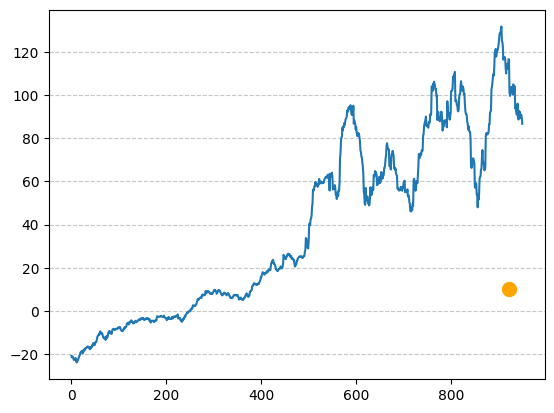

In [71]:
res_1model = train_chaser_1model(chaser_QN, epoch=1000, gamm=0.9, rend=False)
plot_progress(res_1model)

  0%|          | 0/5000 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_32960\3142645502.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_states[index] = torch.tensor(state, dtype=torch.float)
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_32960\3142645502.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_nextstates[index] = torch.tensor(next_state, dtype=torch.float)
100%|██████████| 5000/5000 [12:50<00:00,  6.49it/s]

Best run: 720.0410673543506, at episode: 3889


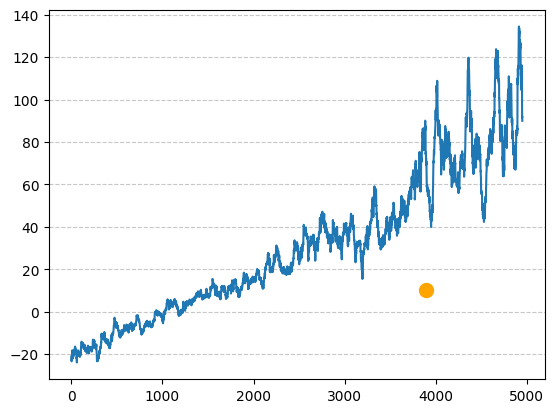

In [74]:
res_1model = train_chaser_1model(chaser_QN, epoch=5000, gamm=0.9, rend=False)
plot_progress(res_1model)

  0%|          | 0/5000 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_32960\3142645502.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_states[index] = torch.tensor(state, dtype=torch.float)
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_32960\3142645502.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_nextstates[index] = torch.tensor(next_state, dtype=torch.float)
100%|██████████| 5000/5000 [19:26<00:00,  4.29it/s]

Best run: 719.4454949480829, at episode: 1675


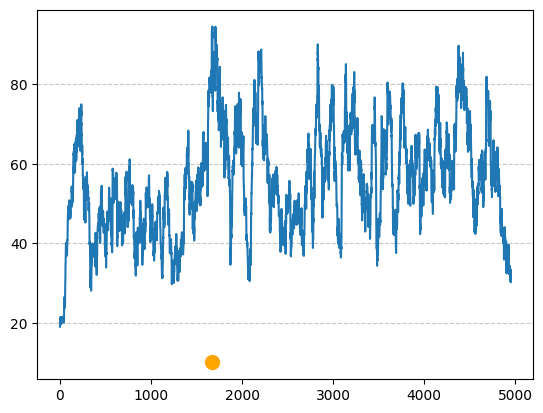

In [ ]:
res_1model = train_chaser_1model(chaser_QN, epoch=5000, gamm=0.8, rend=False)
plot_progress(res_1model)

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_17616\3806821519.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_states[index] = torch.tensor(state, dtype=torch.float)
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_17616\3806821519.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_nextstates[index] = torch.tensor(next_state, dtype=torch.float)
100%|██████████| 1000/1000 [02:03<00:00,  8.07it/s]

Best run: 68.27917568696003, at episode: 561


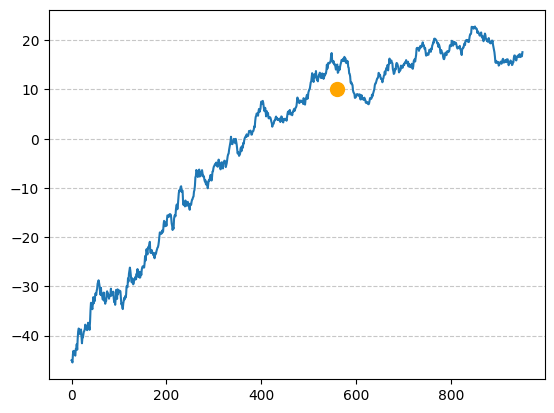

In [54]:
res_chaser = train_chaser(target_QN, epoch=1000, gamm=0.8, rend=False)
plot_progress(res_chaser)

In [25]:
res_chaser = train_chaser(planner_QN, target_QN, epoch=5000, gamm=0.85, rend=False)
plot_progress(res_chaser)

  0%|          | 0/5000 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_32960\3142645502.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_states[index] = torch.tensor(state, dtype=torch.float)
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_32960\3142645502.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_nextstates[index] = torch.tensor(next_state, dtype=torch.float)
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_32960\1628657437.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor

KeyboardInterrupt: 

In [ ]:
# torch.save(target_QN.state_dict(), "./target_QN")
# torch.save(planner_QN.state_dict(), "./planner_QN")

In [42]:
import time

def evaluate_catmouse_model(model, model2, size=20, episodes=10, render=True, epsil = 0, wait=False):
    env = ChaseEscapeEnv(render_mode="human" if render else None)
    model.eval()

    rewards = []

    # time.sleep(3)
    for episode in range(episodes):
        obs, _ = env.reset()
        total_reward = 0
        done = False

        # state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        # rel_action = np.random.randint(low=0, high=3, size=(2,))
        action = env.action_space.sample()
        # with torch.no_grad():
        #     q_values = model(state)
        #     action = torch.argmin(q_values, dim=1).item()


        while not done:

            if not done:

                # print(f"direc {env.direction}")
                # print(f"action {action}, rel action {rel_action}")
                obs, reward, done, _, _ = env.step(action)
                # print(action)
                # print("-"*10)
                total_reward += reward

            state = torch.tensor(obs, dtype=torch.float32)

            print("obs", state)
            with torch.no_grad():
                q_values = model(state)
                # action_index = np.argmax(q_values)
                # action = [action_index//3, action_index%3]

                plan_index = torch.argmax(model(state.unsqueeze(0)))
                # modi_state = torch.tensor(state.squeeze()[0:7])

                # print("modi state", modi_state)

                # modi_state[0] = 0.5
                
                # match plan_index:
                #     case 0:
                #         modi_state[1], modi_state[2] = [1, 1]
                #     case 1:
                #         modi_state[1], modi_state[2] = [-1, 1]
                #     case 3:
                #         modi_state[1], modi_state[2] = [1, -1]
                #     case 4:
                #         modi_state[1], modi_state[2] = [-1, -1]

                # action_index = torch.argmax(model2(modi_state.unsqueeze(0)))
                # action = [action_index//3, action_index%3]

                match plan_index:
                    case 0:
                        action = [2, 2]
                    case 1:
                        action = [0, 2]
                    case 2:
                        action = [2, 0]
                    case 3:
                        action = [0, 0]

            # if np.random.rand() < epsil and not torch.sum(state[0, 0:3] == -1):
            #     rel_action = np.random.randint(low=0, high=3)
            #     # print(f"explored")
            # else:
            #     with torch.no_grad():
            #         q_values = model(state)
            #         # print(q_values)
            #         rel_action = torch.argmax(q_values).item()
                # action = np.random.choice(np.arange(start=0, stop=4), size=1, p=torch.softmax(q_net(state).reshape(4,), dim=0).numpy())[0]
                # action = torch.argmax(q_values, dim=1).item()


            # np.argsort(q_values)
            # for i in range(size+2):
            #     for j in range(size+2):
            #         print(obs[0][i][j], end="")
            #     print()
            # print(obs)


            # for i in np.argsort(q_values[0]):
            #     match i:
            #         case 0:
            #             print(f"left: {int(q_values[0][i])}", end=" ")    
            #         case 1:
            #             print(f"straight: {int(q_values[0][i])}", end=" ")    
            #         case 2:
            #             print(f"right: {int(q_values[0][i])}", end=" ")    
            #         case 3:
            #             print(f"down: {int(q_values[0][i])}", end=" ")    

            print(q_values)
            # for i in np.argsort(q_values[0]):
            #     match i:
            #         case 0:
            #             print(f"right: {int(q_values[0][i])}", end=" ")    
            #         case 1:
            #             print(f"up: {int(q_values[0][i])}", end=" ")    
            #         case 2:
            #             print(f"left: {int(q_values[0][i])}", end=" ")    
            #         case 3:
            #             print(f"down: {int(q_values[0][i])}", end=" ")    

            print()
            
            waiting = wait
            while waiting:
                for event in pygame.event.get():
                    if event.type == pygame.KEYDOWN:
                        if event.key == pygame.K_n:
                            waiting = False
                        if event.key == pygame.K_ESCAPE:
                            done = True
                            waiting = False
            # print(total_reward)
            if render:
                env.render()
    
        rewards.append(total_reward)
        print(f"Episode {episode + 1}: Reward = {total_reward}")

    env.close()
    avg_reward = sum(rewards) / episodes

    print(f"Average reward over {episodes} episodes: {avg_reward}")

In [91]:
# evaluate_catmouse_model(planner_QN, target_QN, episodes=10, wait=False)
evaluate_catmouse_model(chaser_QN, chaser_QN, episodes=10, wait=False)

C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_32960\876784865.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs, dtype=torch.float32)


obs tensor([ 0.5191,  0.9691,  0.2468,  0.3042,  0.7196,  0.0000,  0.1000,  0.6083,
        -0.2935,  0.9301])
tensor([ 0.1669, -0.1462,  0.3005, -0.5554])

obs tensor([ 5.1430e-01,  9.6846e-01,  2.4916e-01,  2.9417e-01,  7.1962e-01,
         1.0000e-01,  1.4901e-09,  5.9481e-01, -3.0081e-01,  9.2721e-01])
tensor([ 0.2812, -0.0048,  0.3346, -0.4648])

obs tensor([ 0.5059,  0.9647,  0.2632,  0.2742,  0.7296,  0.2000, -0.1000,  0.5877,
        -0.3133,  0.9228])
tensor([ 0.3921,  0.1866,  0.3033, -0.3198])

obs tensor([ 4.9145e-01,  9.6260e-01,  2.7091e-01,  2.4417e-01,  7.2962e-01,
         3.0000e-01, -1.4901e-09,  5.7770e-01, -3.3569e-01,  9.1436e-01])
tensor([ 0.6260,  0.4352,  0.5285, -0.0600])

obs tensor([ 0.4708,  0.9623,  0.2721,  0.2042,  0.7196,  0.4000,  0.1000,  0.5653,
        -0.3684,  0.9011])
tensor([0.9228, 0.7730, 0.8539, 0.3487])

obs tensor([ 0.4489,  0.9647,  0.2632,  0.1642,  0.6996,  0.4000,  0.2000,  0.5490,
        -0.4044,  0.8846])
tensor([1.2361, 1.0640, 1.25

KeyboardInterrupt: 

In [ ]:
# While training neural networks, we split the data into batches.
# To improve the training, we need to remove the "correlation" between game states
# The buffer starts storing states and once it reaches maximum capacity, it replaces
# states at random which reduces the correlation.

### The fixed buffer has a bug the index goes from 0 to cap-fixed_buf_cap not fixed-buf_cap to cap


class ExperienceBuffer:
    def __init__(self, capacity, fixed_buffer_cap):
        # self.buffer = deque(maxlen=capacity)
        self.buffer = torch.zeros(size=(capacity, 2), dtype=torch.float)
        self.actions = torch.zeros(size=(capacity, 1), dtype=torch.long)
        self.buffer_states = torch.zeros(size=(capacity, 4), dtype=torch.float)
        self.buffer_nextstates = torch.zeros(size=(capacity, 4), dtype=torch.float)

        self.index = 0

        self.cap = capacity
        self.fixed_buf_cap = fixed_buffer_cap
        
        self.ready = False
        self.buffer_filled = False
        self.fixed_buffer_filled = False
    
    def push(self, state, action, reward, next_state, done):
        
        # self.buffer[self.index] = torch.tensor([state, action, reward, next_state, done])
        # self.buffer[self.index][0] = state
        # self.buffer[self.index][0] = action
        self.buffer[self.index][0] = reward
        # self.buffer[self.index][3] = next_state
        self.buffer[self.index][1] = done

        self.actions[self.index] = action
        self.buffer_states[self.index] = torch.tensor(state, dtype=torch.float)
        self.buffer_nextstates[self.index] = torch.tensor(next_state, dtype=torch.float)
        

        if not self.fixed_buffer_filled:
            if self.index >= self.fixed_buf_cap - 1:
                self.fixed_buffer_filled = True

        if not self.buffer_filled:
            if self.index >= self.cap - 1:
                self.buffer_filled = True

        self.index += 1
        if self.fixed_buffer_filled:
            self.index %= (self.cap-self.fixed_buf_cap)
        else:
            self.index %= (self.cap)

    def sample(self, batch_size):

        if self.buffer_filled:
            batch = torch.randint(0, self.cap-1, size=(batch_size,))
        else:
            batch = torch.randint(0, self.index, size=(batch_size,))

        # states, actions, rewards, next_states, dones = 
        # return states, actions, rewards, next_states, dones

        return self.buffer[batch], self.actions[batch], self.buffer_states[batch], self.buffer_nextstates[batch]
    
    def filled(self, batch):

        if not self.ready:
            if self.index >= batch:
                self.ready = True
        
        return self.ready
